In [1]:
import os
import sys
sys.path.append(os.path.abspath('../src'))
os.environ["PYOPENGL_PLATFORM"] = "egl"

import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from datasets.ho3d import HO3DDataModule as DataModule
from datasets.utils import batch_joints_img_to_cropped_joints
from vis.utils import reverse_transform
from vis.visualizer import HandPoseVisualizer
from utils.camera import transform_joints_between_cameras, camera_to_image_projection


config = {
    "data": {
        "name": "ho3d",
        "batch_size": 1,
        "dataset_dir": "../data/ho3d",
        "mask_size": 32,
        "depth_size": 32,
        "heatmap_size": 32,
        "image_size": 256,
        "mano_models_dir": "../src/mano",
        "num_workers": 0,
        "augment": True,
    }
}

print("initializing data module")
dm = DataModule(config["data"])
print("creating dataloaders")
# dataloader = dm.train_dataloader()
dataloader = dm.test_dataloader()

initializing data module
[Dangerous] Resampled=True, Mode=train
creating dataloaders


starting loop...


0it [00:00, ?it/s]/home/asadali/anaconda3/envs/data2/lib/python3.8/site-packages/manopth/manolayer.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


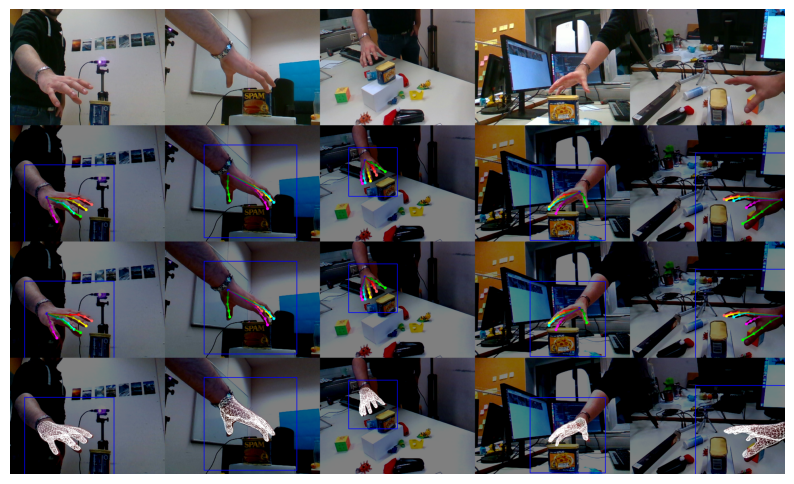

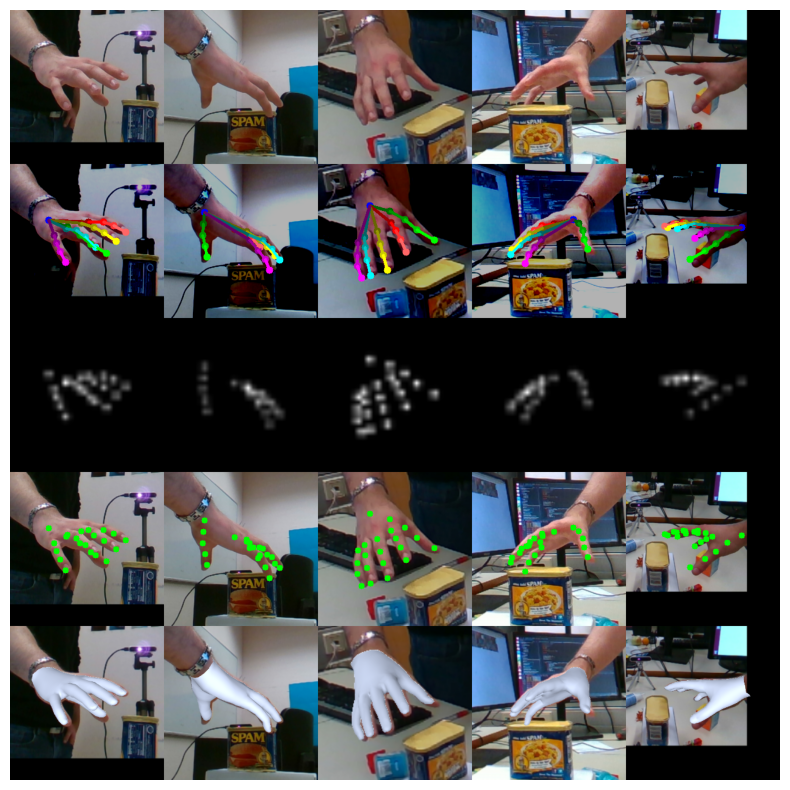

0it [00:11, ?it/s]


In [2]:
print("starting loop...")
for batch_idx, batch in tqdm(enumerate(dataloader)):
    b,views,c,h,w = batch["data"]["rgb"].shape
    idx = 0       # sample number in the batch to visualize
    vis_imgs = {
        "full": [],
        "crop": []
    }
    visualizer = HandPoseVisualizer(batch, mano_dir=config["data"]["mano_models_dir"])
    
    images = batch["data"]["full_rgb"][idx]
    crop_images = batch["data"]["rgb"][idx]
    intr = batch["cam_params"]["intrinsic"][idx]
    extr = batch["cam_params"]["extrinsic"][idx]
    bbox = batch["data"]["bboxes"][idx]
    joints_world = (batch["data"]["joints_cam"] + batch["data"]["root_joint"])[idx]
    vertices_world = (batch["data"]["all_vertices"] + batch["data"]["all_root_joints"])[idx]
    root_idx = batch["data"]["root_idx"][idx].item()

    # visualizer.visualize_3d_joints_and_vertices()
    # visualizer.visualize_3d_absolute_joints_and_vertices()
    
    vis_imgs["full"].append(visualizer.visualize_full_rgb_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["full"].append(visualizer.visualize_joints_2d_on_full_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["full"].append(visualizer.visualize_projected_joints_2d_on_full_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["full"].append(visualizer.visualize_projected_vertices_2d_on_full_image(sample_idx=idx)[:,:,::-1])

    vis_imgs["crop"].append(visualizer.visualize_rgb_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["crop"].append(visualizer.visualize_joints_2d_on_cropped_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["crop"].append(visualizer.visualize_combined_heatmaps(sample_idx=idx))

    # project joints_3d to 2d on all views to check if camera parameters are correct
    proj = []
    joints2d_vis = []
    for v in range(views):
        # joints_world/1000 to convert it into meters
        joints_in_root_camera = transform_joints_between_cameras(joints_world/1000, extr[root_idx], extr[v])
        proj_joints_2d = camera_to_image_projection(joints_in_root_camera, intr[v])[:, :2]
        proj_joints_2d = batch_joints_img_to_cropped_joints(proj_joints_2d.view(-1, 21, 2), bbox[v].view(-1, 4))[0]
        img = reverse_transform(crop_images[v], denormalize=True, IMAGENET_TRANSFORM=True)
        
        for j_idx, joint in enumerate(proj_joints_2d.numpy()):
            img = cv2.circle(img.copy(), (int(joint[0]), int(joint[1])), 5, (0,255,0), -1)
        joints2d_vis.append(img)
    joints2d_vis = np.hstack(joints2d_vis)
    vis_imgs["crop"].append(joints2d_vis)

    mesh2d_vis = []
    for v in range(views):
        intrinsic = intr[v].numpy().copy()
        bb = bbox[v].numpy()
        bb_w, bb_h = bb[2] - bb[0], bb[3] - bb[1]
        intrinsic[2], intrinsic[3] = intrinsic[2] - bb[0], intrinsic[3] - bb[1]
        img = reverse_transform(crop_images[v], denormalize=True, IMAGENET_TRANSFORM=True)
        img_orig = cv2.resize(img.copy(), (bb_w, bb_h))
        mesh_2d = HandPoseVisualizer.generate_mesh_from_verts(
                            vertices_world[v],
                            np.eye(4),
                            intrinsic,
                            img_orig
                        )[0]
        mesh_2d = cv2.resize(mesh_2d, (256, 256))
        mesh2d_vis.append(mesh_2d)
    mesh2d_vis = np.hstack(mesh2d_vis)
    vis_imgs["crop"].append(mesh2d_vis)


    # # test order of the joints by visualizing one by one
    # for v in range(views):
    #     img = reverse_transform(images[v], denormalize=True, IMAGENET_TRANSFORM=True)
    #     for j in range(21):
    #         joint = batch["data"]["joints_img"][0, v, j]
    #         # print(joint)
    #         img = cv2.circle(img.copy(), (int(joint[0]), int(joint[1])), 5, (0,255,0), -1)
    #         print(j)
    #         plt.imshow(img)
    #         plt.show()
    #     break
    
    vis_full = np.vstack(vis_imgs["full"])
    vis_crop = np.vstack(vis_imgs["crop"])
    
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(vis_full)
    plt.axis("off")
    plt.show()

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(vis_crop)
    plt.axis("off")
    plt.show()

    # dump_img = np.vstack([vis_imgs["crop"][1],joints2d_vis])
    # dump_img = cv2.resize(dump_img, (0,0), fx=0.5, fy=0.5)
    # cv2.imwrite(f"./dump/{batch_idx}_crop.png", dump_img)
    
    if batch_idx >= 0: break

# Check if Triangulation is working on Grountruths

In [3]:
from utils.triangulation import triangulate_dlt_torch
from models.metrics import PoseMetrics


def cam_to_world(X_cam, T_cam2world):
    # Add homogeneous coordinate to camera points
    X_cam_hom = torch.cat([X_cam, torch.ones((X_cam.shape[0], 1), device=X_cam.device)], dim=-1)
    # Transform to world coordinates
    X_world = (T_cam2world @ X_cam_hom.T).T
    # Return only the x, y, z components
    return X_world[:, :3]


def create_intrinsics_matrix(intrinsics):
    """
    Converts intrinsics tensor (num_views, 4) to K matrix (num_views, 3, 3).
    
    :param intrinsics: torch.Tensor of shape (num_views, 4) where each row is [fx, fy, cx, cy]
    :return: torch.Tensor of shape (num_views, 3, 3) representing the K matrix for each view
    """
    num_views = intrinsics.shape[0]
    K = torch.zeros((num_views, 3, 3), device=intrinsics.device)

    # Set fx, fy, cx, cy for each view in the K matrix
    K[:, 0, 0] = intrinsics[:, 0]  # fx
    K[:, 1, 1] = intrinsics[:, 1]  # fy
    K[:, 0, 2] = intrinsics[:, 2]  # cx
    K[:, 1, 2] = intrinsics[:, 3]  # cy
    K[:, 2, 2] = 1.0  # bottom-right element is always 1

    return K


for batch_idx, sample in enumerate(dataloader):
    batch_size = sample["data"]["rgb"].shape[0]
    visualizer = HandPoseVisualizer(sample, mano_dir=config["data"]["mano_models_dir"])
    for b in range(batch_size):
        extr = sample["cam_params"]["extrinsic"][b].float()   # [v, 4, 4], cam2world
        extr_inv = torch.linalg.inv(extr) # [v, 4, 4]                      world2cam
        intr = sample["cam_params"]["intrinsic"][b].float()   # [v, 4]

        if "intrinsic_mat" in sample["cam_params"]:
            Ks = sample["cam_params"]["intrinsic_mat"][b]
        else:
            Ks = create_intrinsics_matrix(intr)  # [v, 3, 3]

        crops = sample["data"]["rgb"][b]
        bbox = sample["data"]["bboxes"][b]
        gt_joints_2d = sample["data"]["joints_img"][b]
        gt_joints_crop_2d = sample["data"]["joints_crop_img"][b]
        gt_joints_cam = sample["data"]["joints_cam"][b]  # from camera 1
        gt_root = sample["data"]["root_joint"][b]        # from camera 1
        gt_all_joints_cam = sample["data"]["all_joints_cam"][b]
        gt_all_roots = sample["data"]["all_root_joints"][b]
        gt_joints_cam_abs = gt_joints_cam + gt_root
        gt_all_joints_cam_abs = gt_all_joints_cam + gt_all_roots

        ############## HO3D dataset has no camera at world origin ###############
        # we need to have gt_joints at world origin
        # cam_to_world() expects the joints to be in same unit as extr translation vector (mm)
        root_idx = 0        # can be used any idx
        gt_joints_world = cam_to_world(gt_all_joints_cam_abs[root_idx]/1000, extr[root_idx]) * 1000
        ####################################################################################################    
        pred_joints_cam_abs = triangulate_dlt_torch(gt_joints_2d, Ks, extr_inv) * 1000
        
        mpjpe = PoseMetrics.mpjpe(pred_joints_cam_abs, gt_joints_world)
        pa_mpjpe = PoseMetrics.pa_mpjpe(pred_joints_cam_abs.unsqueeze(0), gt_joints_world.unsqueeze(0))
        print(f"Batch {batch_idx}, mpjpe: {mpjpe:.4f}, pa_mpjpe: {pa_mpjpe:.4f}")
        
    # break
    if batch_idx > 9: break

Batch 0, mpjpe: 0.0005, pa_mpjpe: 0.0001
Batch 1, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 2, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 3, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 4, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 5, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 6, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 7, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 8, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 9, mpjpe: 0.0006, pa_mpjpe: 0.0001
Batch 10, mpjpe: 0.0006, pa_mpjpe: 0.0001


# Check Inconsistent Camera Extrinsics

In [4]:
# from tqdm import tqdm
# # Initialize a variable to store extrinsics from the first batch
# reference_extrinsics = None
# is_consistent = True  # Flag to track consistency

# config = {
#     "data": {
#         "name": "ho3d",
#         "batch_size": 16,
#         "dataset_dir": "../data/ho3d",
#         "mask_size": 32,
#         "depth_size": 32,
#         "heatmap_size": 32,
#         "image_size": 256,
#         "mano_models_dir": "../src/mano",
#         "num_workers": 0,
#     }
# }

# dm = DataModule(config["data"])
# # dataloader = dm.test_dataloader()
# dataset = dm.train_set

# # Initialize a list to store unique extrinsics
# unique_extrinsics = []

# for idx, sample in tqdm(enumerate(dataset)):
#     current_extrinsics = sample["cam_params"]["extrinsic"]

#     # Check if this extrinsics matrix is already in the list of unique extrinsics
#     if not any(np.array_equal(current_extrinsics, unique_extrinsic) for unique_extrinsic in unique_extrinsics):
#         unique_extrinsics.append(current_extrinsics)

# # Output the unique extrinsics and their count
# print(f"Found {len(unique_extrinsics)} unique extrinsic matrices.")
# for i, extrinsic in enumerate(unique_extrinsics):
#     print(f"Unique Extrinsic {i + 1}:\n", extrinsic)

# # Found 2 unique extrinsic matrices.
# # Unique Extrinsic 1:
# #  [[[ 0.7342037  -0.21442924 -0.6441778   0.2428462 ]
# #   [ 0.67748547  0.16954914  0.715728   -0.27834898]
# #   [-0.04425322 -0.9619112   0.26975632  0.00168996]
# #   [ 0.          0.          0.          1.        ]]

# #  [[ 0.7726148   0.12782614  0.62187374 -0.37359372]
# #   [-0.6333466   0.08725534  0.76893336 -0.30339417]
# #   [ 0.04402798 -0.9879509   0.14837302  0.01868116]
# #   [ 0.          0.          0.          1.        ]]

# #  [[ 0.25595525  0.35884717 -0.8976166   0.6389388 ]
# #   [ 0.9500221  -0.2650552   0.16493547  0.00398083]
# #   [-0.17873134 -0.8949718  -0.408755    0.28885666]
# #   [ 0.          0.          0.          1.        ]]

# #  [[-0.77200216 -0.06635599 -0.6321467   0.31851926]
# #   [ 0.6315527  -0.19240569 -0.75108004  0.43580943]
# #   [-0.07178997 -0.9790694   0.19044492  0.02347848]
# #   [ 0.          0.          0.          1.        ]]

# #  [[-0.8281126  -0.24845229  0.5024948  -0.19454312]
# #   [-0.55686283  0.261804   -0.78826547  0.4447795 ]
# #   [ 0.06429122 -0.9325932  -0.35515705  0.26908493]
# #   [ 0.          0.          0.          1.        ]]]
# # Unique Extrinsic 2:
# #  [[[-0.96508175  0.05435036  0.2562484  -0.09846219]
# #   [-0.26045763 -0.30333254 -0.9165976   0.39481938]
# #   [ 0.02791107 -0.9513335   0.30689666 -0.01383363]
# #   [ 0.          0.          0.          1.        ]]

# #  [[-0.4228052  -0.20785621 -0.88206095  0.46372524]
# #   [ 0.9057442  -0.06536945 -0.41875327  0.15350942]
# #   [ 0.02938063 -0.97597265  0.2159031  -0.01448622]
# #   [ 0.          0.          0.          1.        ]]

# #  [[-0.64096403 -0.26504177  0.72035956 -0.5675702 ]
# #   [-0.76018476  0.3490764  -0.5479642   0.3191066 ]
# #   [-0.10622713 -0.8988318  -0.42522612  0.30740425]
# #   [ 0.          0.          0.          1.        ]]

# #  [[ 0.42903095  0.08850725  0.89894325 -0.47544348]
# #   [-0.9018737   0.09767472  0.42081282 -0.21665888]
# #   [-0.05055904 -0.991275    0.12172784  0.06127903]
# #   [ 0.          0.          0.          1.        ]]

# #  [[ 0.98460394  0.06828612 -0.1609103   0.00989704]
# #   [ 0.17479491 -0.37744808  0.90938425 -0.4349112 ]
# #   [ 0.00136304 -0.9235096  -0.38357294  0.28649837]
# #   [ 0.          0.          0.          1.        ]]]
